In [48]:
import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

from datetime import datetime as dt

import sys

# Adicione o caminho do subdiretório ao caminho de busca do Python
sys.path.append('modelos')

import xgb
import nn
import lg
import rf

## Recebendo os dados e Preparando eles para a classificação
Eu recebo o dataset da Premier-League faço o pré-processamento dele, a gente vai dividir o treino em temporadas de 2000 até 2018, onde o teste vai ser 2019 até 2021

Além disso, como vamos testar para classificação multiclasse e binária nós eu faço o tratamento do target para os dois casos. Vale lembrar também que graças a características das nossas features que levam em consideração dados de 3 jogos atrás, resolvemos excluir os 3 primeiros jogos de cada time, dessa forma, todas as tuplas terão informações de 3 jogos que realmente já aconteceram.

In [49]:
# Lendo a base de dados

loc = "./Premier-League/"
dataset = pd.read_csv(loc + "premier_league2001-2021.csv")

In [50]:
# Tirando as primeiras 3 semanas rodadas de cada ano

datasetParsed = dataset.drop(dataset.loc[(dataset["MW"] == 1)  | (dataset["MW"] == 2) | (dataset["MW"] == 3)].index)
datasetParsed

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,...,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffFormPts3,DiffLP
30,2000-09-05,Man United,Bradford,6,0,H,5,2,3,1,...,0,0,0,0,0.500000,0.250000,0.250000,1,1,-16.0
31,2000-09-05,Sunderland,West Ham,1,1,D,3,4,5,7,...,0,0,0,0,-0.500000,-0.750000,0.500000,2,2,-2.0
32,2000-09-05,Tottenham,Everton,3,2,H,4,5,4,4,...,0,0,0,0,0.000000,0.250000,0.000000,0,0,-3.0
33,2000-09-06,Charlton,Southampton,1,1,D,7,6,8,7,...,0,0,0,0,-0.250000,-0.250000,0.250000,1,1,3.0
34,2000-09-06,Chelsea,Arsenal,2,2,D,5,7,5,4,...,0,0,0,0,0.000000,0.750000,-0.500000,-2,-2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7975,2021-05-23,Liverpool,Crystal Palace,2,0,H,66,41,42,64,...,0,0,0,0,0.631579,-0.605263,0.578947,7,6,-13.0
7976,2021-05-23,Man City,Everton,5,0,H,78,47,32,43,...,0,0,0,0,1.210526,0.105263,0.631579,2,-1,-10.0
7977,2021-05-23,Sheffield United,Burnley,1,0,H,19,33,63,54,...,0,0,0,0,-1.157895,-0.552632,-0.500000,0,0,-1.0
7978,2021-05-23,West Ham,Southampton,3,0,H,59,47,47,65,...,0,0,0,0,0.315789,-0.473684,0.500000,0,-2,5.0


In [51]:
selectedColumns = ["Date","DiffLP", "DiffPts", "DiffFormPts3",  # Diferenças
                    "HTWinStreak3", "ATWinStreak3","HTLossStreak3", "ATLossStreak3", # Streaks
                    "HTGS", "ATGS", "HTGC", "ATGC", # Gols Feitos e Recebidos de cada um
                    "HTFormPts3", "ATFormPts3", # Pontos ganhos nas últimas semanas
                    "HTGD", "ATGD", "HomeTeamLP", "AwayTeamLP", # Diferença de Gol
                    "HM1","HM2","HM3","AM1","AM2","AM3", # Resultado dos últimos 3 jogos
                    "HSA", "ASA", "HSTA", "ASTA", "FTR", "FTHG", "FTAG"] # Chutes e Chutes a Gol
                    # FTHG e FTAG serão retirados depois devido eles darem informações de Y, mas serão utilizados na árvore regressora

datasetSelected = datasetParsed[selectedColumns]

In [52]:
columns_to_encode = ["HM1", "HM2", "HM3", "AM1", "AM2", "AM3"] 
# Para fazer o OneHotEncoding das variáveis HM e AM

# Realiza o one-hot encoding nas colunas selecionadas
datasetSelected_encoded = pd.get_dummies(datasetSelected, columns=columns_to_encode)

datasetSelected_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7350 entries, 30 to 7979
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7350 non-null   object 
 1   DiffLP         7350 non-null   float64
 2   DiffPts        7350 non-null   float64
 3   DiffFormPts3   7350 non-null   int64  
 4   HTWinStreak3   7350 non-null   int64  
 5   ATWinStreak3   7350 non-null   int64  
 6   HTLossStreak3  7350 non-null   int64  
 7   ATLossStreak3  7350 non-null   int64  
 8   HTGS           7350 non-null   int64  
 9   ATGS           7350 non-null   int64  
 10  HTGC           7350 non-null   int64  
 11  ATGC           7350 non-null   int64  
 12  HTFormPts3     7350 non-null   int64  
 13  ATFormPts3     7350 non-null   int64  
 14  HTGD           7350 non-null   float64
 15  ATGD           7350 non-null   float64
 16  HomeTeamLP     7350 non-null   float64
 17  AwayTeamLP     7350 non-null   float64
 18  HSA    

In [53]:
# Separando em treino e teste pelo tempo e dando um shuffle em tudo

train = datasetSelected_encoded.loc[
                datasetSelected_encoded["Date"] < "2015-08-11"].sample(frac = 1, random_state = 42)

test = datasetSelected_encoded.loc[
                datasetSelected_encoded["Date"] >= "2015-08-11"].sample(frac = 1, random_state = 42)


goalsTrain = train[["FTHG", "FTAG"]]
goalsTest = test[["FTHG", "FTAG"]]

print(train.shape)
print(test.shape)
goalsTrain

(5250, 43)
(2100, 43)


,FTHG,FTAG
1587,0,1
2940,3,0
3977,1,3
2752,1,0
3172,3,0
...,...,...
3362,1,0
4102,1,1
5641,0,2
5676,1,1


In [54]:
y_train = np.array(train["FTR"]).reshape(-1, 1)
y_test = np.array(test["FTR"]).reshape(-1, 1)

x_train = pd.DataFrame(np.array(train.drop(["FTR", "Date", "FTHG", "FTAG"], axis = 1)))
x_test = np.array(test.drop(["FTR", "Date", "FTHG", "FTAG"], axis = 1))

# Separando em x e y

In [55]:
# Normalização dos dados em MinMax de X

scaler = MinMaxScaler()
x_train_encoded = scaler.fit_transform(x_train)
x_test_encoded = scaler.transform(x_test)

In [56]:
# trabalhando e criando os Y's
# o encoded é utilizado no rede neural
# o multiclass é usado na regressão logistica multiclasse
# o binário é utilizado nos modelos com predição binária

encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train).toarray()
y_test_encoded = encoder.transform(y_test).toarray()

y_train_multiclass = train["FTR"].astype("category").cat.codes
y_test_multiclass =  test["FTR"].astype("category").cat.codes

functionHNH = np.vectorize(lambda x: "H" if x=="H" else "NH")

y_train_ = functionHNH(y_train)
y_test_ = functionHNH(y_test)

y_train_binary = np.where(y_train_ == "H", 1, 0)
y_test_binary = np.where(y_test_ == "H", 1, 0)

In [57]:
# preparando os dados para a classificação binária



## Treinamento e Validação dos Modelos

Para Multiclasse vamos treinar uma rede neural simples, com 5 camadas, e para a classificação binária será feita um número maior de modelos.

Nós dois casos foi feito GridSearch Cross-Validation separadamente com os dados de treino e, após a seleção dos melhores parâmetros foi feito o treino verdadeiramente e é feito o teste com os dados de teste.

In [58]:
# Todos os modelos que vamos utilizar

rand_for_mult = rf.RandomForestMulticlass()
rand_for_bin = rf.RandomForestBinary()

log_reg_mult = lg.LogisticRegressionMulticlass()
log_reg_bin  = lg.LogisticRegressionBinary()

redeNeural = nn.NeuralNetwork() 
xgboost = xgb.XGB()

0.1 0.7 0.0001
0.05 0.7 0.0001
0.01 0.7 0.0001
0.1 0.8 0.0001
0.05 0.8 0.0001
0.01 0.8 0.0001
0.1 0.9 0.0001
0.05 0.9 0.0001
0.01 0.9 0.0001
0.1 0.7 0.0005
0.05 0.7 0.0005
0.01 0.7 0.0005
0.1 0.8 0.0005
0.05 0.8 0.0005
0.01 0.8 0.0005
0.1 0.9 0.0005
0.05 0.9 0.0005
0.01 0.9 0.0005
{'learning_rate': 0.01, 'momentum': 0.7, 'weight_decay': 0.0005}


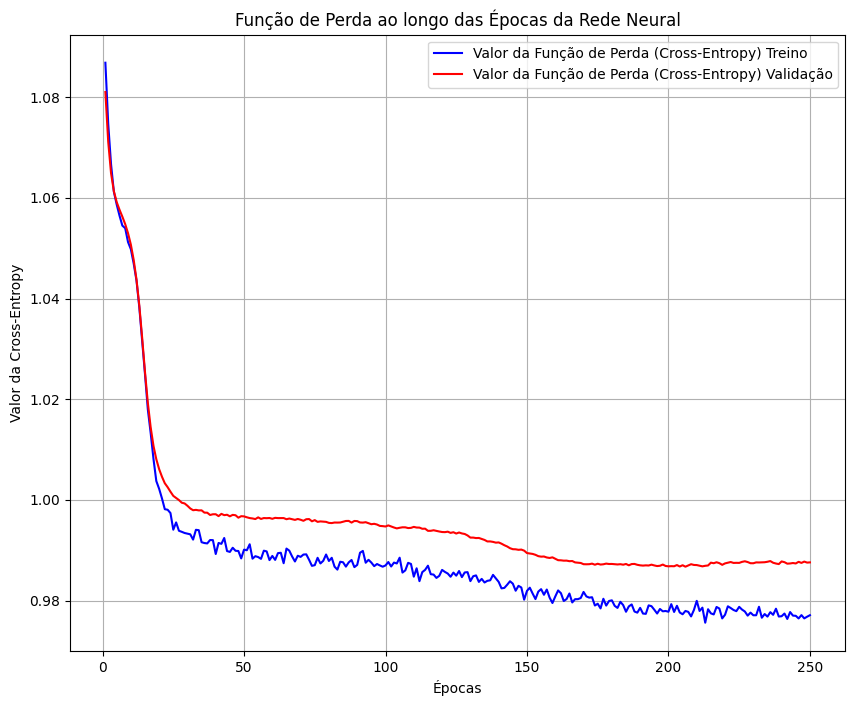

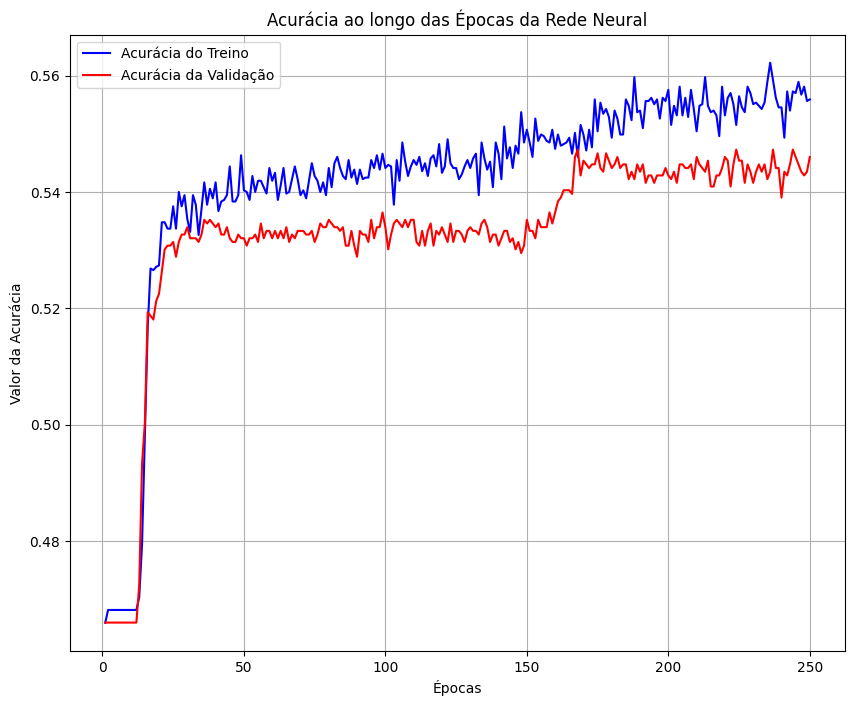

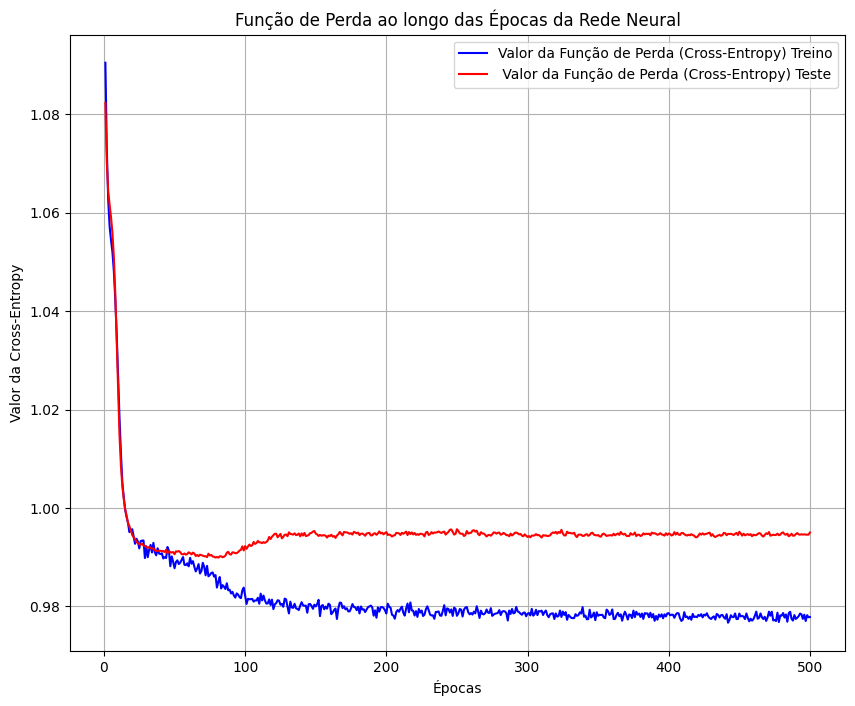

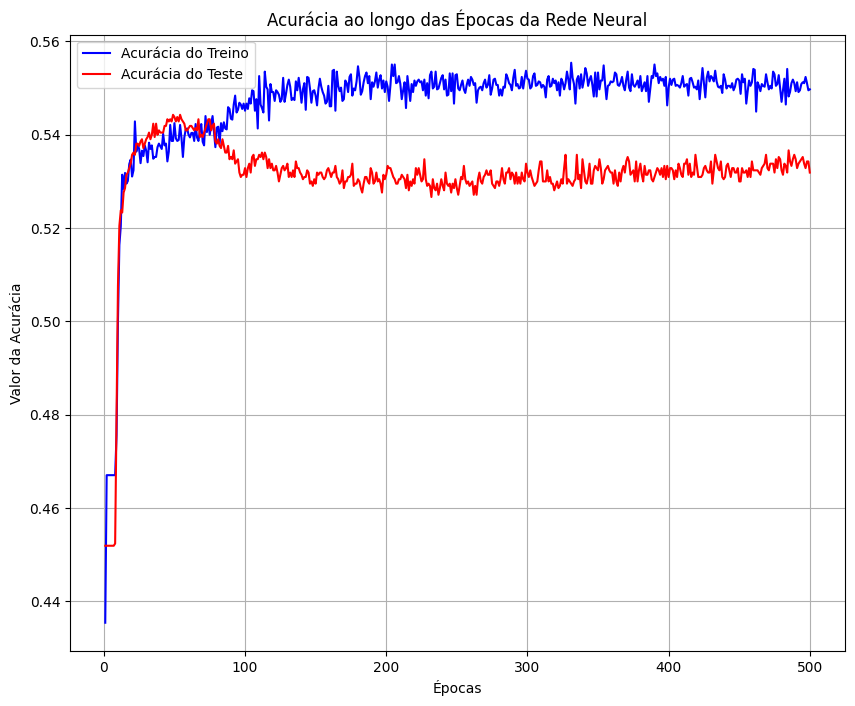

(0.552,
 0.5096447728126435,
 0.47542686325605477,
 tensor(0.9763, grad_fn=<DivBackward1>),
 0.5319047619047619,
 0.4657480629966331,
 0.44515252464559046,
 tensor(0.9950, grad_fn=<DivBackward1>))

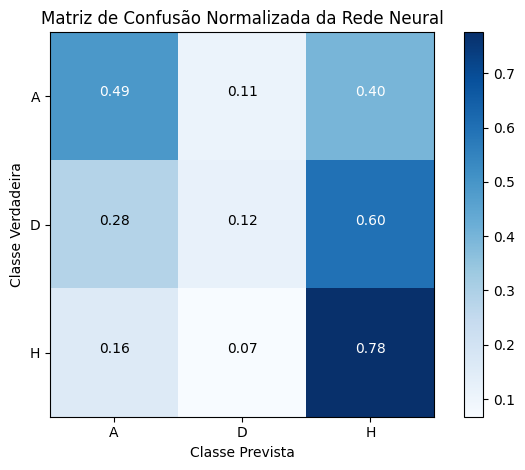

In [59]:
best_params = redeNeural.train_validation(x_train_encoded, y_train_encoded, 250)

print(best_params)

outputs_nn = redeNeural.test(x_train_encoded, y_train_encoded, x_test_encoded, y_test_encoded,
                                  best_params, 500)


outputs_nn

Começando validação...


Validação terminada.
Melhores parametros: {'max_depth': 5, 'max_leaf_nodes': None, 'n_estimators': 100}
{'max_depth': 5, 'max_leaf_nodes': None, 'n_estimators': 100}
Treinando modelo...
0.6668571428571428 0.6466666666666666


(0.6668571428571428,
 0.640656262505002,
 0.6467380327206625,
 0.6466666666666666,
 0.6070320579110652,
 0.6127348643006263)

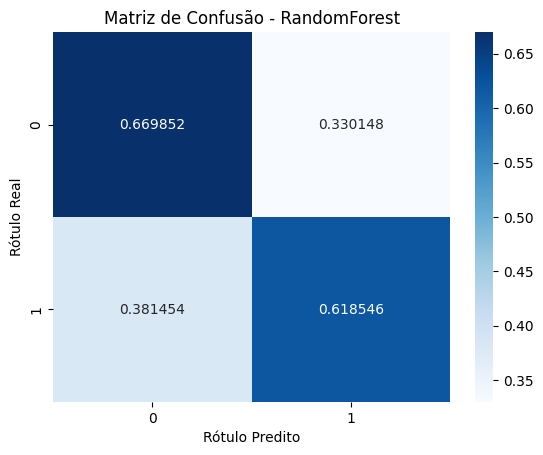

In [60]:
best_params = rand_for_bin.train_validation(x_train_encoded, y_train_binary, goalsTrain)

print(best_params)

out_rf_bin = rand_for_bin.test(x_train_encoded, y_train_binary, x_test_encoded, y_test_binary, goalsTrain, goalsTest, best_params)

out_rf_bin

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 1587 to 950
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   FTHG    5250 non-null   int64
 1   FTAG    5250 non-null   int64
dtypes: int64(2)
memory usage: 123.0 KB
Começando validação...


c:\Users\murilo.pinheiro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Validação terminada.
Melhores parametros: {'max_depth': 5, 'max_leaf_nodes': None, 'n_estimators': 10}
{'max_depth': 5, 'max_leaf_nodes': None, 'n_estimators': 10}
Treinando modelo...
0.4398095238095238 0.44904761904761903


(0.4398095238095238,
 0.38636689791092055,
 0.3747797473545951,
 0.44904761904761903,
 0.3841380041766877,
 0.3792340742164757)

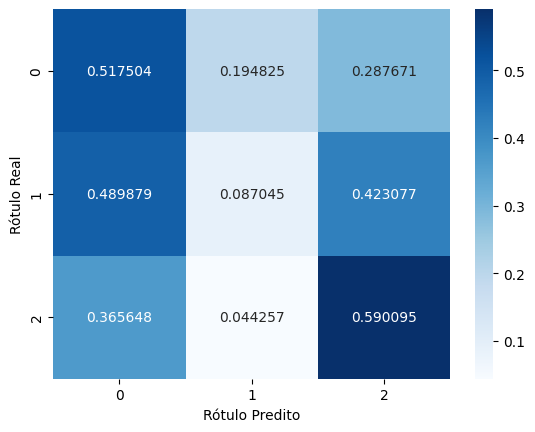

In [61]:
goalsTrain.info()
best_params = rand_for_mult.train_validation(x_train_encoded, y_train_encoded, goalsTrain)

print(best_params)

out_rf_mult = rand_for_mult.test(x_train_encoded, y_train_encoded,
                   x_test_encoded, y_test_encoded,
                   goalsTrain, goalsTest, best_params)

out_rf_mult

[0 1 0 ... 0 0 1]


(0.668,
 0.6591827570722946,
 0.6274845052361616,
 0.6719047619047619,
 0.6473922902494331,
 0.6237028945931186)

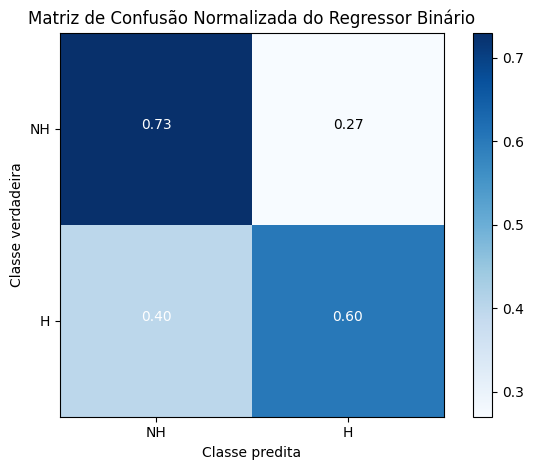

In [62]:
y_train_binary = y_train_binary.flatten()
y_test_binary = y_test_binary.flatten()
print(y_train_binary)
outputs_lg_bintrain = log_reg_bin.train_validation(x_train_encoded, y_train_binary, max_iter=1000)

# Não fizemos GridSearch na Regressão Logística

outputs_lg_bintest = log_reg_bin.test(x_test_encoded, y_test_binary)

outputs_lg_bin = outputs_lg_bintrain + outputs_lg_bintest

outputs_lg_bin

(0.5459047619047619,
 0.5007612541425348,
 0.44174174294998086,
 0.5447619047619048,
 0.4804930445399582,
 0.43409057186805144)

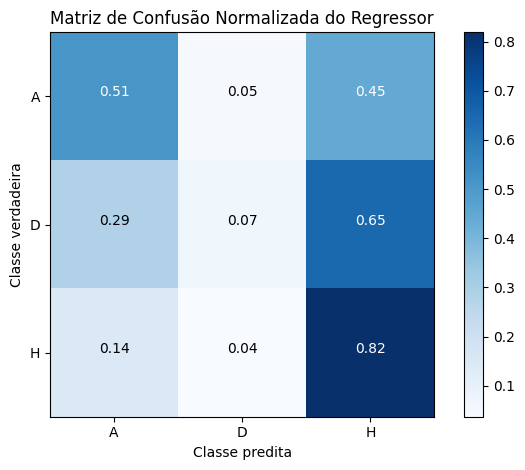

In [63]:
outputs_lg_multtrain = log_reg_mult.train_validation(x_train_encoded, y_train_multiclass, max_iter=1000)

outputs_lg_multtest = log_reg_mult.test(x_test_encoded, y_test_multiclass)

outputs_lg_mult = outputs_lg_multtrain + outputs_lg_multtest

outputs_lg_mult

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.

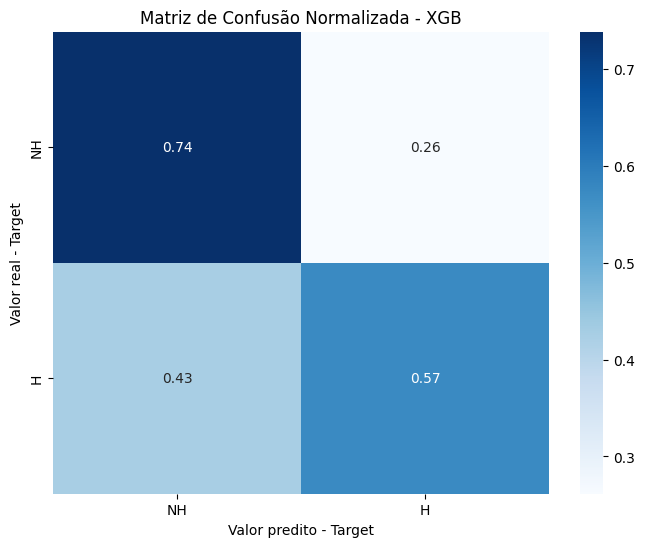

(0.6977142857142857,
 0.6977594878829446,
 0.6579004095710282,
 0.6638095238095238,
 0.6437869822485207,
 0.6064659977703456)

In [64]:
best_params = xgboost.train_validation(x_train_encoded, y_train_binary)

print(best_params)

outputs_xgb = xgboost.test(x_train_encoded, y_train_binary, x_test_encoded, y_test_binary, best_params)

outputs_xgb

In [ ]:
nn_acc_tr = 0.552
nn_prec_tr = 0.5096447728126435
nn_f1_tr = 0.47542686325605477
#nn_tr_loss  = 0.9763
nn_acc_ts = 0.5319047619047619
nn_prec_ts = 0.4657480629966331
nn_f1_ts  = 0.44515252464559046
#nn_ts_loss = 0.9950

In [ ]:
rfb_acc_tr = 0.6668571428571428
rfb_prec_tr =  0.640656262505002
rfb_f1_tr =  0.6467380327206625
rfb_acc_ts =  0.6466666666666666
rfb_prec_ts = 0.6070320579110652
rfb_f1_ts = 0.6127348643006263

In [ ]:
rfm_acc_tr = 0.4398095238095238
rfm_prec_tr =  0.38636689791092055
rfm_f1_tr =  0.3747797473545951
rfm_acc_ts =  0.44904761904761903
rfm_prec_ts = 0.3841380041766877
rfm_f1_ts = 0.3792340742164757

In [ ]:
lgb_acc_tr = 0.668
lgb_prec_tr = 0.6591827570722946
lgb_f1_tr = 0.6274845052361616
lgb_acc_ts = 0.6719047619047619
lgb_prec_ts = 0.6473922902494331
lgb_f1_ts = 0.6237028945931186

In [ ]:
lgm_acc_tr = 0.5459047619047619
lgm_prec_tr = 0.5007612541425348
lgm_f1_tr = 0.44174174294998086
lgm_acc_ts = 0.5447619047619048
lgm_prec_ts = 0.4804930445399582
lgm_f1_ts = 0.43409057186805144

In [ ]:
xgb_acc_tr = 0.6977142857142857
xgb_prec_tr =0.6977594878829446
xgb_f1_tr =  0.6579004095710282
xgb_acc_ts = 0.6638095238095238
xgb_prec_ts = 0.6437869822485207
xgb_f1_ts = 0.6064659977703456